In [233]:
import numpy as np
import pickle
from pathlib import Path
import os

import torch
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms

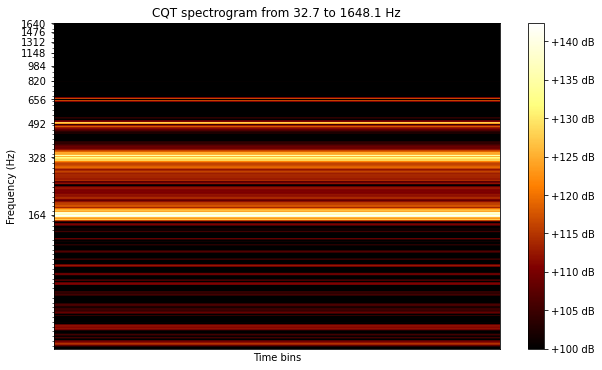

In [234]:
spec_path = Path('../data/processed/time_intervals=1/resolution=5/')
instr = 'vocal_acoustic'
instr_id = 'vocal_acoustic_009'
instr_file = 'vocal_acoustic_009-052-075.spec'
with open(spec_path/instr/instr_id/instr_file, 'rb') as f:
    spec = pickle.load(f)
spec.plot(db_thresh=100, axis_harm=10)

In [235]:
def listdir(path):
    files = os.listdir(path)
    if '.DS_Store' in files:
        files.remove('.DS_Store')
    return files

In [307]:
class SpectrogramDataset(torch.utils.data.Dataset):
    """CQT spectrograms dataset"""
    
    def __init__(self, root, instruments, spec_transform=None, label_transform=None):
        """
        Args:
            root (string): Directory with all the arrays
            instruments (list): List of instruments to keep
        """
        root = Path(root)
        nested_files =  [[root/instr/instr_id/instr_file
                          for instr_id in listdir(root/instr)
                          for instr_file in listdir(root/instr/instr_id)]
                          for instr in instruments]
        self.files = [f for instr_files in nested_files
                        for f in instr_files]
        self.class_counts = [len(instr_files) for instr_files in nested_files]
        self.instruments = instruments
        self.spec_transform = spec_transform
        self.label_transform = label_transform
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        # Load pickled Spectrogram object
        with open(self.files[idx], 'rb') as f:
            spec = pickle.load(f)
        # Extract spectrogram
        spec = np.abs(spec).T
        if self.spec_transform:
            spec = self.spec_transform(spec)
        # Extract label
        instr = '_'.join(self.files[idx].name.split('_')[:-1])
        label = self.instruments.index(instr)
        if self.label_transform:
            label = self.label_transform(label)
        # Sample
        return (spec, label)

In [308]:
# Load dataset
root_dir = '../data/processed/time_intervals=1/resolution=5/'
instruments = ['keyboard_acoustic', 'guitar_acoustic']#listdir(root_dir)
spec_dataset = SpectrogramDataset(root_dir, instruments)
# Calculate mean and std
specs = np.hstack([spec_dataset[i][0] for i in range(len(spec_dataset))])
mean = specs.mean()
std = specs.std()

0


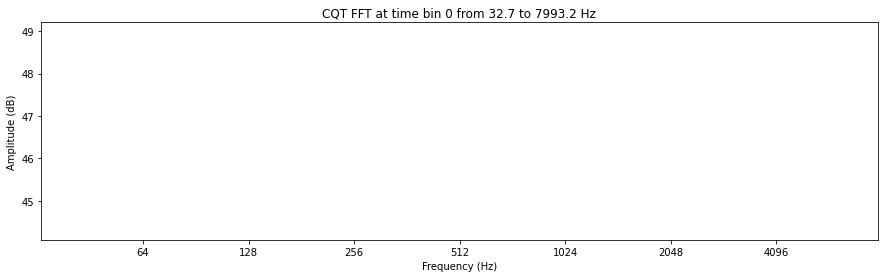

In [309]:
# View example
sample = spec_dataset[0]
print(sample[1])
sample[0].plot_fft()

In [310]:
def stratified_split(dataset, split=0.8, seed=42):
    """
    Stratified train test split 
    """
    train_indices = []
    test_indices = []
    class_delim = np.cumsum([0] + dataset.class_counts)
    # Get indices
    for i in range(1, len(class_delim)):
        indices = np.arange(class_delim[i-1], class_delim[i])
        idx_split = int(np.floor(split * indices.shape[0]))
        np.random.seed(seed)
        np.random.shuffle(indices)
        train_indices.extend(list(indices[:idx_split]))
        test_indices.extend(list(indices[idx_split:]))
    # PyTorch sampler
    train_sampler = SubsetRandomSampler(train_indices)
    test_sampler = SubsetRandomSampler(test_indices)
    return train_sampler, test_sampler

In [395]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    
    def __init__(self, float32=False):
        self.float32 = float32
    
    def __call__(self, item):
        tensor = torch.from_numpy(np.asarray(item))
        return tensor.float() if self.float32 else tensor


class Normalise(object):
    """Normalise 1-channel image Tensor to mean=0 std=1"""
    
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, item):
        return (item - self.mean) / self.std

In [402]:
spec_transform = transforms.Compose([
    ToTensor(float32=True),
    Normalise(mean, std)
])
label_transform = ToTensor()
spec_dataset = SpectrogramDataset(root_dir, instruments, spec_transform, label_transform)
train_sampler, test_sampler = stratified_split(spec_dataset)
train_loader = torch.utils.data.DataLoader(spec_dataset, batch_size=32,
                                           sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(spec_dataset, batch_size=32,
                                           sampler=test_sampler)

In [427]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.pool = nn.MaxPool1d(2, 2)
        self.conv1 = nn.Conv1d(1, 16, 5)
        self.conv2 = nn.Conv1d(16, 32, 5)
        self.fc1 = nn.Linear(116 * 32, 120) 
        self.fc2 = nn.Linear(120, 64)
        self.fc3 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # 1x476 in, 16x236 out
        x = self.pool(F.relu(self.conv2(x))) # 16x236 in, 32x116 out 
        x = x.view(-1, 32*116)               # flatten each mini-batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x))
        return x

net = Net()

In [431]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [432]:
for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

/Users/julian/projects/deep-music/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[1,   100] loss: 0.024
[1,   200] loss: 0.024
[2,   100] loss: 0.024
[2,   200] loss: 0.024
[3,   100] loss: 0.024
[3,   200] loss: 0.023
[4,   100] loss: 0.024
[4,   200] loss: 0.023
[5,   100] loss: 0.023
[5,   200] loss: 0.023
[6,   100] loss: 0.023
[6,   200] loss: 0.023
[7,   100] loss: 0.023
[7,   200] loss: 0.023
[8,   100] loss: 0.023
[8,   200] loss: 0.023
[9,   100] loss: 0.023
[9,   200] loss: 0.023
[10,   100] loss: 0.023
[10,   200] loss: 0.023
[11,   100] loss: 0.023
[11,   200] loss: 0.023
[12,   100] loss: 0.023
[12,   200] loss: 0.023
[13,   100] loss: 0.022
[13,   200] loss: 0.023
[14,   100] loss: 0.022
[14,   200] loss: 0.023
[15,   100] loss: 0.023
[15,   200] loss: 0.022
[16,   100] loss: 0.022
[16,   200] loss: 0.023
[17,   100] loss: 0.023
[17,   200] loss: 0.022
[18,   100] loss: 0.023
[18,   200] loss: 0.023
[19,   100] loss: 0.023
[19,   200] loss: 0.022
[20,   100] loss: 0.022
[20,   200] loss: 0.022
[21,   100] loss: 0.022
[21,   200] loss: 0.022
[22,   100